# Cardiovascular disease diagnosis using cardiac magnetic resonance radiomics and machine learning



The purpose of this Assignment is to identify the machine learning algorithm that is best-suited for the classification problem and compute its perfomance using metrics.

### Dataset Overview

For the purposes of this project, you will utilize data extracted from the ACDC challenge
dataset. The dataset contains 100 patients, evenly distributed across the five classes of
interest:
1. Normal case (NORM),
2. Heart failure with infarction (MINF),
3. Dilated cardiomyopathy (DCM),
4. Hypertrophic cardiomyopathy (HCM),
5. Abnormal right ventricle (RV)

The file ACDC_radiomics.csv contains the radiomics for three structures of interest (left ventricle, myocardium, right ventricle) at two different time-points of the cardiac cycle (end-systole and end-diastole) extracted from the CMR and the respective segmentations of the structures of interest. The radiomics where calculated using the Pyradiomics library. Additionally, patient height and weight data are included. Finally, the patients' class, i.e., the target output, is provided in the “class” column.


Datafile structure:
Each row of the file represents a patient, with columns corresponding to radiomic features, patient weight, height, and class labels. In total, you are provided with 643 radiomics of three different categories (107 per structure per time-point):
* Shape,
* First order, and
* Texture (GLCM, GLSZM, GLRLM, NGTDM, GLDM).

The naming convention for the characteristics in the .csv is as follows:
original_RadiomicCategory_FeatureName_Structure_Phase, where RadiomicCategory represents shape, firstorder, glcm, glszm, glrlm, ngtdm, or gldm. FeatureName indicates the name of the feature. Structure refers to one of the structures of interest: myocardium (MYO),
left ventricle (LV), or right ventricle (RV). Phase represents either end-diastole (ED) or endsystole (ES).
For example: original_ngtdm_Strength_MYO_ES.

Let’s have a look the first a few rows of the data.

In [2]:
#Load data
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Installation of required packages.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier




In [4]:
# Read the dataset and create the dataframe.
%matplotlib inline

df = pd.read_csv('./gdrive/My Drive/Colab Machine Learning/1st assessment/ACDC_radiomics.csv')
df.head()

,original_shape_Elongation_LV_ED,original_shape_Flatness_LV_ED,original_shape_LeastAxisLength_LV_ED,original_shape_MajorAxisLength_LV_ED,original_shape_Maximum2DDiameterColumn_LV_ED,original_shape_Maximum2DDiameterRow_LV_ED,original_shape_Maximum2DDiameterSlice_LV_ED,original_shape_Maximum3DDiameter_LV_ED,original_shape_MeshVolume_LV_ED,original_shape_MinorAxisLength_LV_ED,...,original_glszm_ZonePercentage_MYO_ES,original_glszm_ZoneVariance_MYO_ES,original_ngtdm_Busyness_MYO_ES,original_ngtdm_Coarseness_MYO_ES,original_ngtdm_Complexity_MYO_ES,original_ngtdm_Contrast_MYO_ES,original_ngtdm_Strength_MYO_ES,height,weight,class
0,0.560917,0.110560,6.592758,59.630582,45.398238,64.776539,64.007812,65.199693,5674.000000,33.447817,...,0.053567,40384.123570,19.552355,0.000993,36.034390,0.010496,0.091329,184,95,DCM
1,0.454960,0.088323,5.730218,64.877933,40.311289,64.140471,61.000000,67.446275,5015.833333,29.516875,...,0.028344,130808.332098,29.225756,0.000722,17.238110,0.006596,0.045024,160,70,DCM
2,0.541682,0.105418,6.711577,63.666027,48.041649,66.843100,59.135438,68.080834,7817.666667,34.486772,...,0.041404,92088.926893,20.732684,0.001106,13.916093,0.004455,0.069372,165,77,DCM
3,0.487949,0.105906,6.726159,63.510529,44.407207,66.370174,66.007575,66.475559,5629.166667,30.989912,...,0.150855,5232.431686,5.158496,0.000848,216.183657,0.025431,0.208797,159,46,DCM
4,0.442150,0.095225,7.186765,75.471150,68.066144,77.472576,50.487622,77.472576,8550.083333,33.369563,...,0.040613,91705.803093,18.086404,0.000710,41.886924,0.005266,0.123346,165,77,DCM


In [6]:
print(df.shape) #dataframe dimension

(100, 645)


We have 645 variables and 100 patients or rows.

In [10]:
nrows, ncols = 5, 5

nfigs = np.ceil(df.shape[1] / (nrows * ncols)).astype(int)
print(nfigs)

26


In [7]:
print(df.groupby('class').size())

class
DCM     20
HCM     20
MINF    20
NOR     20
RV      20
dtype: int64


We have five types of class in the dataset equally distributed between patients.

### Exploratory Data Analysis

Box plot for each numeric variable will give us a clearer idea of the distribution of the input variables:

In [11]:
# Define the number of rows, columns and figures
nrows, ncols, nfigs = 5, 5, 26

# Loop over the figures
for fignum in range(nfigs):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

    # Loop over the subplots in the current figure
    for i, ax in enumerate(axes.flat):
        var_index = fignum * nrows * ncols + i
        if var_index < df.shape[1]:
            df.iloc[:, var_index].plot(kind='box', ax=ax)
            ax.set_title(f"Variable {var_index+1}", fontsize=8)
            ax.set(xlabel='', ylabel='')

    # Adjust the layout
    plt.tight_layout()

    # Add a main title for the figure
    fig.suptitle(f"Box Plot for variables {fignum*nrows*ncols+1} to {min((fignum+1)*nrows*ncols, df.shape[1])}", fontsize=12, y=1.02)

    # Save the figure to a file
    plt.savefig(f'fruits_box_{fignum}.png')

    # Show the figure
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Note: there is an error because the last column (class) doesn't contain numeric values.

We can select from here the more "normal" distributions based on the number of outliers (max of 2) and getting the variables number 1,4,6,7,8,10,13,18,25,31,38,45,47,50,53,55,57,60,64,65,66,67,72,75,78,80,81,82,83,84,86,87,88,96,97,100,111,114,117,125,127,138,145,151,154,157,159,160,162,164,167,171,179,185,186,188,189,191,193,195,207,213,218,221,224,225,227,239,243,245,252,258,259,260,261,262,266,267,271,274,278,280,284,286,289,293,295,296,298,301,302,308,310,311,313,314,322,334,339,340,343,346,348,352,359,361,363,364,366,367,368,369,371,372,373,374,376,378,382,385,386,393,400,402,403,405,408,409,417,418,421,425,431,432,433,434,435,436,438,440,441,446,448,459,468,470,471,473,475,479,481,483,485,488,492,498,500,509,510,512,516,522,525,527,528,532,539,542,545,546,548,560,564,566,573,579,580,582,583,587,588,592,595,599,601,607,614,617,619,623,629,634,635,643,644

In [5]:
# Defining a new dataframe based on the selected columns with 0 indexing.
selected_columns = [0, 3, 5, 6, 7, 9, 12, 17, 24, 30, 37, 44, 46, 49, 52, 54, 56, 59, 63, 64, 65, 66, 71, 74, 77, 79, 80, 81, 82, 83, 85, 86, 87, 95, 96, 99, 110, 113, 116, 124, 126, 137, 144, 150, 153, 156, 158, 159, 161, 163, 166, 170, 178, 184, 185, 187, 188, 190, 192, 194, 206, 212, 217, 220, 223, 224, 226, 238, 242, 244, 251, 257, 258, 259, 260, 261, 265, 266, 270, 273, 277, 279, 283, 285, 288, 292, 294, 295, 297, 300, 301, 307, 309, 310, 312, 313, 321, 333, 338, 339, 342, 345, 347, 351, 358, 360, 362, 363, 365, 366, 367, 368, 370, 371, 372, 373, 375, 377, 381, 384, 385, 392, 399, 401, 402, 404, 407, 408, 416, 417, 420, 424, 430, 431, 432, 433, 434, 435, 437, 439, 440, 445, 447, 458, 467, 469, 470, 472, 474, 478, 480, 482, 484, 487, 491, 497, 499, 508, 509, 511, 515, 521, 524, 526, 527, 531, 538, 541, 544, 545, 547, 559, 563, 565, 572, 578, 579, 581, 582, 586, 587, 591, 594, 598, 600, 606, 613, 616, 618, 622, 628, 633, 634, 642, 643, 644]

# Create the new DataFrame df_subset
df_normal = df.iloc[:, selected_columns]

Now we can see the distribution with a histogram for each selected variable

In [16]:
# Define the number of rows and columns per figure
nrows, ncols = 5, 5

# Calculate the number of figures needed
nfigs = np.ceil(df_normal.shape[1] / (nrows * ncols)).astype(int)

# Loop over the figures
for fignum in range(nfigs):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    axs = axs.ravel()

    # Loop over the subplots in the current figure
    for i in range(nrows * ncols):
        var_index = fignum * nrows * ncols + i
        if var_index < df_normal.shape[1]:
            var = df_normal.columns[var_index]
            sns.histplot(data=df_normal, x=var, ax=axs[i], kde=True, bins=30)
            axs[i].set_title(f"Variable {var_index+1}", fontsize=8)
    # Adjust the layout
    plt.tight_layout()

    # Add a main title for the figure
    fig.suptitle(f"Histogram for Variables {fignum*nrows*ncols+1} to {min((fignum+1)*nrows*ncols, df_normal.shape[1])}", fontsize=12, y=1.02)

    # Save the figure to a file
    plt.savefig(f'fruits_hist_{fignum}.png')

    # Show the figure
    plt.show()




Output hidden; open in https://colab.research.google.com to view.

From these plots we can see that the following variables don't show a normal distribution: 8,10,12,14,15,16,17,19,21,22,23,24,27,28,29,30,32,33,36,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,68,69,70,72,73,74,75,76,77,78,81,82,83,84,85,87,88,89,90,92,95,99,100,101,103,104,106,107,108,110,111,113,114,115,117,119,120,122,124,125,126,132,133,134,135,136,137,138,139,141,142,144,145,146,147,150,152,153,155,156,157,161,162,163,164,165,166,170,176,179,180,184,185,191,192

In [6]:
columns_to_drop = [7, 9, 11, 13, 14, 15, 16, 18, 20, 21, 22, 23, 26, 27, 28, 29, 31, 32, 35, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 94, 98, 99, 100, 102, 103, 105, 106, 107, 109, 110, 112, 113, 114, 116, 118, 119, 121, 123, 124, 125, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 143, 144, 145, 146, 149, 151, 152, 154, 155, 156, 160, 161, 162, 163, 164, 165, 169, 175, 178, 179, 183, 184, 190, 191]
df_normal2 = df_normal.drop(df_normal.columns[columns_to_drop], axis=1)

Now we can look at the correlation between the variables we kept, for this purpose, we can make a scatter matrix.

In [18]:
# Define the number of rows and columns per figure
nrows, ncols = 5, 5

# Calculate the number of figures needed
nfigs = np.ceil(df_normal2.shape[1] / (nrows * ncols)).astype(int)

# Loop over the figures
for fignum in range(nfigs):
    # Select a subset of the dataframe for the current figure
    start_col = fignum * nrows * ncols
    end_col = min((fignum + 1) * nrows * ncols, df_normal2.shape[1])
    subset = df_normal2.iloc[:, start_col:end_col]

    # Create the pair plot for the subset
    g = sns.pairplot(subset, diag_kind="hist")

    # Adjust the layout
    plt.tight_layout()

    # Add a main title for the figure
    g.fig.suptitle(f"Scatter-matrix for Variables {start_col+1} to {end_col}", fontsize=12, y=1.02)

    # Save the figure to a file
    plt.savefig(f'fruits_scatter_matrix_{fignum}.png')

    # Show the figure
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Some pairs of attributes are correlated (mass and width). This suggests a high correlation and a predictable relationship.

### Create Training and Test Sets and Apply Scaling

Splitting data into training and test sets is a common practice in machine learning and data analysis.

By splitting the data into a training set and a test set, we can train the model on the training set and evaluate its performance on the test set. This allows us to estimate how well the model will perform on new, unseen data, and to make adjustments to the model or the training process as necessary.

A common practice is to use 80% of the data for training and 20% for testing, but this ratio can vary depending on various factors as the size of the dataset, the nature of the problem, and the desired level of accuracy.

On the other hand, **scaling data** is a common preprocessing step that ensures that all features are on a similar scale, which can help to improve the performance of some machine learning algorithms. There are different methods to scale data as the one we are using, min max scaling.

MinMaxScaler transform features by scaling each feature to a given range.
This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [21]:
#data X Y
X = df_normal2.drop('class', axis=1)
y = df_normal2['class']

#SPLIT DATA: TRAINING AND TEST
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=100)

#MinMaxScaler transform
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
print(X_train," and", X_test) #transformed with MinMaxScaler
print(X_train.shape) #train
print(X_test.shape)

[[0.13161482 0.12903521 0.09312529 ... 0.33331453 0.19230769 0.21590909]
 [0.5095518  0.21594184 0.27416109 ... 0.59291066 0.         0.        ]
 [0.80086981 0.15513541 0.16233707 ... 0.31995666 0.38461538 0.26136364]
 ...
 [0.3442581  0.23708076 0.24462375 ... 0.2123232  0.26923077 0.32954545]
 [0.40922535 0.38714193 0.36168564 ... 0.73185366 0.65384615 0.53409091]
 [0.0035008  0.23558574 0.17230763 ... 0.38232219 0.25       0.29545455]]  and [[0.51331919 0.5265626  0.69148466 ... 0.80234815 0.38461538 0.27272727]
 [0.41551255 0.25998961 0.25817151 ... 1.25386287 0.48076923 0.15909091]
 [0.66253447 0.17805857 0.16200479 ... 0.64135985 0.34615385 0.28409091]
 ...
 [0.31652685 0.3037208  0.30427321 ... 1.04562847 0.76923077 0.39772727]
 [0.52997142 0.05031072 0.04320517 ... 0.53141468 0.57692308 0.39772727]
 [0.14787385 0.23666504 0.20601382 ... 0.15060087 0.38461538 0.27272727]]
(80, 79)
(20, 79)


### Build Models

Now we are gonna build some differents models and see which one is the best for our case based on different metrics. We will see 4 metrics (precision, recall, f1-score and accuracy)


*   **Accuracy:** the proportion of correctly classified instances out of the total number of instances.
*   **Precision:** the proportion of true positive instances out of all positive predictions.
*   **Recall:** the proportion of true positive instances out of all actual positive instances.
*   **F1-score:** the harmonic mean of precision and recall, which balances both metrics.











Also, we will see see the confusion matrix, which is used to describe the performance of a classification model on a set of test data.

In [23]:
# Function to plot confusion matrix:
def CM(ytrue, ypred, clases=None, normalize = False):
  conf_matrix=confusion_matrix(ytrue, ypred)
  fig, ax = plt.subplots(figsize=(8, 8))
  ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                  xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Label")
  ax.set_ylabel("True Label")
  plt.show()


*   **Logistic Regression**

A llitle of theory in: https://www.geeksforgeeks.org/understanding-logistic-regression/



1.   Logistic regression is a powerful statistical technique used for classification problems, where you want to predict the probability of an event occurring based on one or more independent variables. Think of it like a yes/no or true/false prediction, but with a confidence score attached.
2.   Modeling: Logistic regression builds a mathematical model that relates the features (independent variables) to the probability of the target event (dependent variable). It uses a sigmoid function, which squeezes the predicted probabilities between 0 and 1.






In [24]:
#We are going to adjust a classification model, the logistic regression model, to predict the classes of fruits
logreg = LogisticRegression()
logreg.fit(X_train, y_train) #training set

pred = logreg.predict(X_test) #We are going to adjust a classification model, the logistic regression model, to predict the classes of fruits.
accuracy= accuracy_score(y_test, pred) #The classes are predicted with the test set and the metric is evaluated from this
print(classification_report(y_test, pred))

print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(accuracy))



              precision    recall  f1-score   support

         DCM       1.00      0.50      0.67         2
         HCM       0.60      0.43      0.50         7
        MINF       0.33      0.67      0.44         3
         NOR       0.50      0.60      0.55         5
          RV       1.00      0.67      0.80         3

    accuracy                           0.55        20
   macro avg       0.69      0.57      0.59        20
weighted avg       0.64      0.55      0.56        20

Accuracy of Logistic regression classifier on training set: 0.97
Accuracy of Logistic regression classifier on test set: 0.55


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


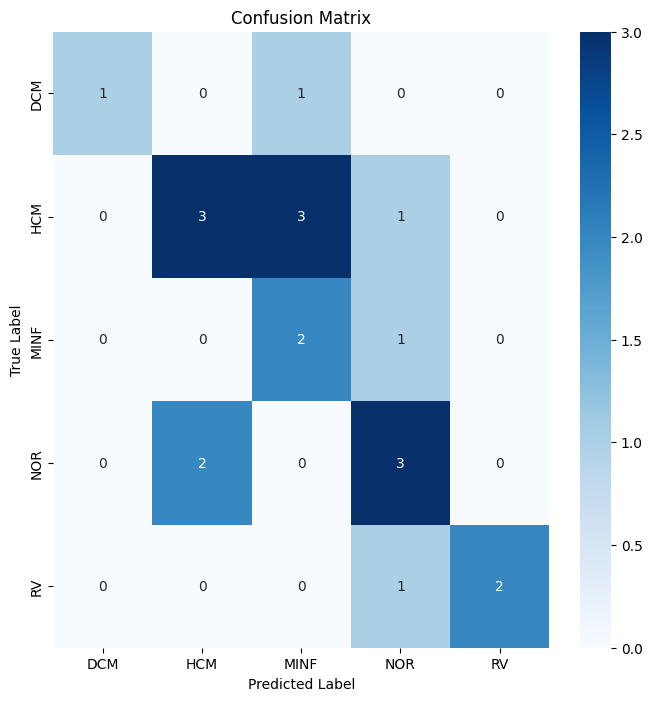

In [25]:
#Confusion matrix
CM(y_test,pred)

Now we are going to do the same with other very common methods in ML for classification, which will be explained in other lessons.

The metrics for each of these methods will be displayed.



*   **Decision Tree**

Theory and introduction in: https://www.geeksforgeeks.org/decision-tree/


*   A decision tree is a machine learning algorithm used for both classification and regression tasks. It works by building a tree-like structure where:
*   Internal nodes represent questions based on features (attributes) of the data. Branches represent the possible answers to those questions. Leaves represent the final predictions or classifications.

In [26]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)
accuracy_clf= accuracy_score(y_test, pred_clf)
print(classification_report(y_test, pred_clf))

print('Accuracy of DecisionTree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of DecisionTree classifier on test set: {:.2f}'.format(accuracy_clf))

              precision    recall  f1-score   support

         DCM       0.00      0.00      0.00         2
         HCM       0.67      0.29      0.40         7
        MINF       0.40      0.67      0.50         3
         NOR       0.38      0.60      0.46         5
          RV       1.00      0.67      0.80         3

    accuracy                           0.45        20
   macro avg       0.49      0.44      0.43        20
weighted avg       0.54      0.45      0.45        20

Accuracy of DecisionTree classifier on training set: 1.00
Accuracy of DecisionTree classifier on test set: 0.45


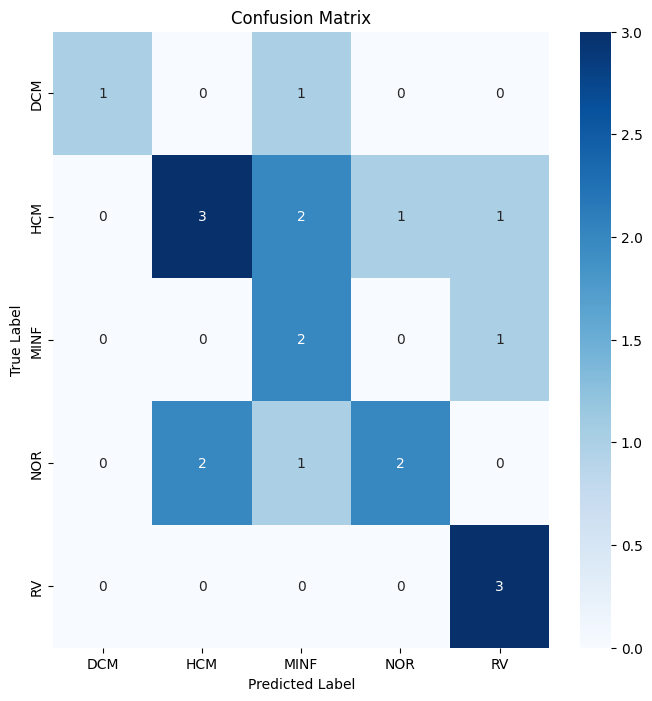

In [ ]:
CM(y_test,pred_clf)

*   **Linear Discriminant Analysis (FDA)**

theory: https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/



*   Find a linear combination of features that maximizes the separation between different classes. Think of it as creating a dividing line or hyperplane that best separates the data points of different classes.




In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
pred_lda = lda.predict(X_test)
accuracy_lda= accuracy_score(y_test, pred_lda)
print(classification_report(y_test, pred_lda))

print('Accuracy of LDA classifier on training set: {:.2f}'.format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'.format(accuracy_lda))

              precision    recall  f1-score   support

         DCM       0.67      1.00      0.80         2
         HCM       0.67      0.29      0.40         7
        MINF       0.10      0.33      0.15         3
         NOR       0.00      0.00      0.00         5
          RV       0.67      0.67      0.67         3

    accuracy                           0.35        20
   macro avg       0.42      0.46      0.40        20
weighted avg       0.41      0.35      0.34        20

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 0.35


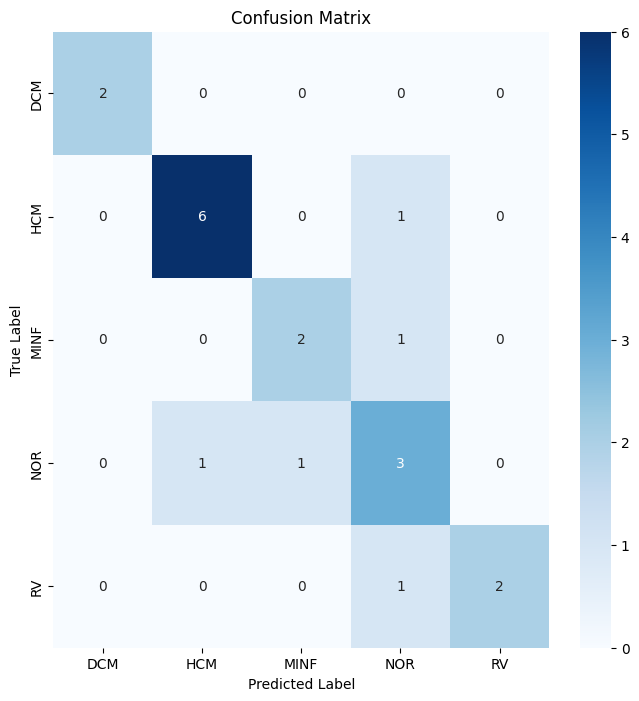

In [ ]:
CM(y_test,pred_lda)

*   **K-Nearest Neighbors**

theory: https://www.geeksforgeeks.org/k-nearest-neighbours/

K-Nearest Neighbors (KNN) is a non-parametric, supervised machine learning algorithm used for both classification and regression tasks. It works by making predictions based on the similarity of a new data point to its k nearest neighbors in the training data.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
accuracy_knn= accuracy_score(y_test, pred_knn)
print(classification_report(y_test, pred_knn))

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(accuracy_knn))

              precision    recall  f1-score   support

         DCM       0.33      0.50      0.40         2
         HCM       1.00      0.43      0.60         7
        MINF       0.12      0.33      0.18         3
         NOR       0.20      0.20      0.20         5
          RV       1.00      0.33      0.50         3

    accuracy                           0.35        20
   macro avg       0.53      0.36      0.38        20
weighted avg       0.60      0.35      0.40        20

Accuracy of K-NN classifier on training set: 0.82
Accuracy of K-NN classifier on test set: 0.35


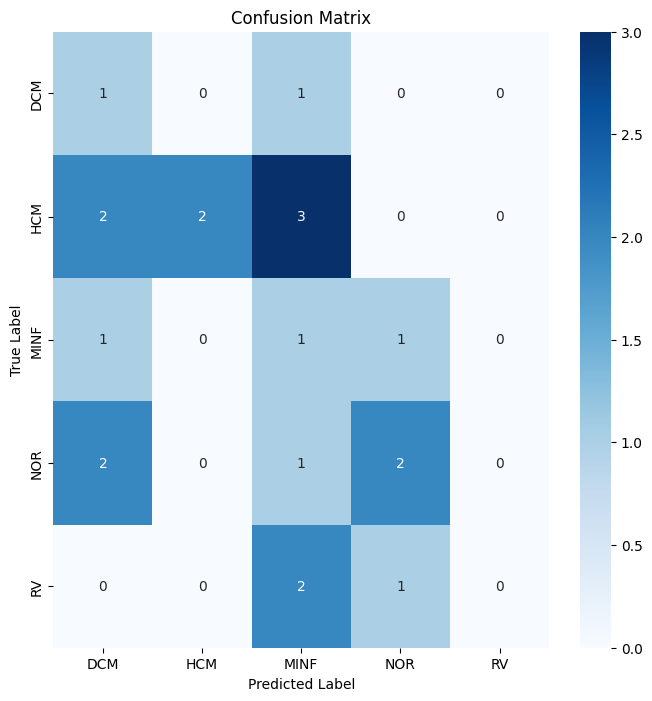

In [ ]:
CM(y_test,pred_knn)

*   **Support Vector Machine**

theory: https://www.geeksforgeeks.org/introduction-to-support-vector-machines-svm/



*   What it is: A powerful machine learning algorithm used for classification and regression, known for its ability to handle complex data and high dimensionality.

*   How it works: Imagine separating different data points (e.g., emails marked spam vs. not spam) by drawing a line (hyperplane) in a high-dimensional space. SVMs find the optimal hyperplane that maximizes the margin between the two categories,



In [29]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
accuracy_svm= accuracy_score(y_test, pred_svm)
print(classification_report(y_test, pred_svm))

print('Accuracy of SVC classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of SVC classifier on test set: {:.2f}'.format(accuracy_svm))

              precision    recall  f1-score   support

         DCM       0.33      0.50      0.40         2
         HCM       0.75      0.43      0.55         7
        MINF       0.25      0.67      0.36         3
         NOR       0.33      0.20      0.25         5
          RV       1.00      0.67      0.80         3

    accuracy                           0.45        20
   macro avg       0.53      0.49      0.47        20
weighted avg       0.57      0.45      0.47        20

Accuracy of SVC classifier on training set: 0.82
Accuracy of SVC classifier on test set: 0.45


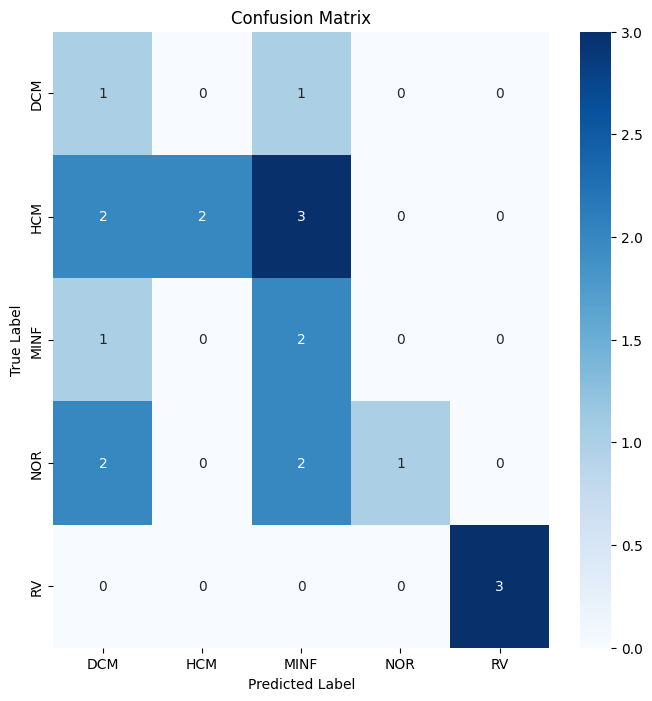

In [ ]:
CM(y_test,pred_svm)

Parameter tuning and we must be critical of the decision made; it should be extrapolable and repeatable.

The KNN algorithm was the most accurate model that we tried. In this case, we see an indication of no error made on the test set. However, we have to keep in mind that the **test set is small**.

Plot the Decision Boundary of the k-NN Classifier

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
def plot_df_knn(X, y, n_neighbors, weights):
    X_mat = X[['height', 'weight']].values
    y_mat = y.values
# Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)
# Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])
    plt.xlabel('height (cm)')
    plt.ylabel('weight (kg)')
    plt.title("4-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.show()
plot_df_knn(X_train, y_train, 5, 'uniform')

KeyboardInterrupt: 

To find the best number of neighbors, we can do parameter tuning, which is to fit the model with different values and see which one obtains the best result.
For this particular dateset, we obtain the highest accuracy when k=5.

See more examples in: https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2



<!--NAVIGATION-->
Based partially in internet, only for teaching pourposes.

See in: https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2

# Feature selection algorithm

# AutoML using H2O



In [7]:
#Download the library
!pip install h2o

In [8]:
#H2O AutoML
import h2o
from h2o.automl import H2OAutoML
h2o.__version__

'3.44.0.3'

In [9]:
import multiprocessing
multiprocessing.cpu_count()

import psutil
psutil.virtual_memory()

svmem(total=13609443328, available=12579131392, percent=7.6, used=688934912, free=7998222336, active=1318526976, inactive=3976400896, buffers=91885568, cached=4830400512, shared=9687040, slab=215310336)

In [10]:
#IMPORT LIBRARY H2O
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame

#h2o.init() IN A DISTRIBUTED SERVER
h2o.init(ip="127.0.0.1", max_mem_size_GB = 200, nthreads = 10)

Checking whether there is an H2O instance running at http://127.0.0.1:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp54agp7h9
  JVM stdout: /tmp/tmp54agp7h9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp54agp7h9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_kbyyh3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,200 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [11]:
#example using iris data
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


#pandas to h2o frame (alternative)
df_h2o = h2o.H2OFrame(df_normal2)
#iris_df = h2o.import_file(url)

#print data
print(df_h2o) #see data

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  original_shape_Elongation_LV_ED    original_shape_MajorAxisLength_LV_ED    original_shape_Maximum2DDiameterRow_LV_ED    original_shape_Maximum2DDiameterSlice_LV_ED    original_shape_Maximum3DDiameter_LV_ED    original_shape_MinorAxisLength_LV_ED    original_shape_SurfaceVolumeRatio_LV_ED    original_firstorder_Minimum_LV_ED    original_glcm_Correlation_LV_ED    original_glcm_Imc2_LV_ED    original_gldm_DependenceVariance_LV_ED    original_gldm_LargeDependenceHighGrayLevelEmphasis_LV_ED    original_glrlm_LowGrayLevelRunEmphasis_LV_ED    original_glrlm_RunLengthNonUniformity_LV_ED    original_glrlm_ShortRunLowGrayLevelEmphasis_LV_ED    original_glszm_SizeZoneNonUniformityNormalized_LV_ED    original_glszm_SmallAreaEmphasis_LV_ED    original_shape_MajorAxisLength_RV_ED    original_shape_Maximum2DDiameterSlice_RV_ED    original_shape_MinorAxisLength_RV_ED    original_glcm_MCC_RV_ED    original_

In [12]:
!pip install -U scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(df, test_size=0.15, random_state=17) #TRAIN 85%, TEST 15%

In [13]:
#pandas to h2o frame type
hf = h2o.H2OFrame(x_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
hf.head()

original_shape_Elongation_LV_ED,original_shape_Flatness_LV_ED,original_shape_LeastAxisLength_LV_ED,original_shape_MajorAxisLength_LV_ED,original_shape_Maximum2DDiameterColumn_LV_ED,original_shape_Maximum2DDiameterRow_LV_ED,original_shape_Maximum2DDiameterSlice_LV_ED,original_shape_Maximum3DDiameter_LV_ED,original_shape_MeshVolume_LV_ED,original_shape_MinorAxisLength_LV_ED,original_shape_Sphericity_LV_ED,original_shape_SurfaceArea_LV_ED,original_shape_SurfaceVolumeRatio_LV_ED,original_shape_VoxelVolume_LV_ED,original_firstorder_10Percentile_LV_ED,original_firstorder_90Percentile_LV_ED,original_firstorder_Energy_LV_ED,original_firstorder_Entropy_LV_ED,original_firstorder_InterquartileRange_LV_ED,original_firstorder_Kurtosis_LV_ED,original_firstorder_Maximum_LV_ED,original_firstorder_MeanAbsoluteDeviation_LV_ED,original_firstorder_Mean_LV_ED,original_firstorder_Median_LV_ED,original_firstorder_Minimum_LV_ED,original_firstorder_Range_LV_ED,original_firstorder_RobustMeanAbsoluteDeviation_LV_ED,original_firstorder_RootMeanSquared_LV_ED,original_firstorder_Skewness_LV_ED,original_firstorder_TotalEnergy_LV_ED,original_firstorder_Uniformity_LV_ED,original_firstorder_Variance_LV_ED,original_glcm_Autocorrelation_LV_ED,original_glcm_ClusterProminence_LV_ED,original_glcm_ClusterShade_LV_ED,original_glcm_ClusterTendency_LV_ED,original_glcm_Contrast_LV_ED,original_glcm_Correlation_LV_ED,original_glcm_DifferenceAverage_LV_ED,original_glcm_DifferenceEntropy_LV_ED,original_glcm_DifferenceVariance_LV_ED,original_glcm_Id_LV_ED,original_glcm_Idm_LV_ED,original_glcm_Idmn_LV_ED,original_glcm_Idn_LV_ED,original_glcm_Imc1_LV_ED,original_glcm_Imc2_LV_ED,original_glcm_InverseVariance_LV_ED,original_glcm_JointAverage_LV_ED,original_glcm_JointEnergy_LV_ED,original_glcm_JointEntropy_LV_ED,original_glcm_MCC_LV_ED,original_glcm_MaximumProbability_LV_ED,original_glcm_SumAverage_LV_ED,original_glcm_SumEntropy_LV_ED,original_glcm_SumSquares_LV_ED,original_gldm_DependenceEntropy_LV_ED,original_gldm_DependenceNonUniformity_LV_ED,original_gldm_DependenceNonUniformityNormalized_LV_ED,original_gldm_DependenceVariance_LV_ED,original_gldm_GrayLevelNonUniformity_LV_ED,original_gldm_GrayLevelVariance_LV_ED,original_gldm_HighGrayLevelEmphasis_LV_ED,original_gldm_LargeDependenceEmphasis_LV_ED,original_gldm_LargeDependenceHighGrayLevelEmphasis_LV_ED,original_gldm_LargeDependenceLowGrayLevelEmphasis_LV_ED,original_gldm_LowGrayLevelEmphasis_LV_ED,original_gldm_SmallDependenceEmphasis_LV_ED,original_gldm_SmallDependenceHighGrayLevelEmphasis_LV_ED,original_gldm_SmallDependenceLowGrayLevelEmphasis_LV_ED,original_glrlm_GrayLevelNonUniformity_LV_ED,original_glrlm_GrayLevelNonUniformityNormalized_LV_ED,original_glrlm_GrayLevelVariance_LV_ED,original_glrlm_HighGrayLevelRunEmphasis_LV_ED,original_glrlm_LongRunEmphasis_LV_ED,original_glrlm_LongRunHighGrayLevelEmphasis_LV_ED,original_glrlm_LongRunLowGrayLevelEmphasis_LV_ED,original_glrlm_LowGrayLevelRunEmphasis_LV_ED,original_glrlm_RunEntropy_LV_ED,original_glrlm_RunLengthNonUniformity_LV_ED,original_glrlm_RunLengthNonUniformityNormalized_LV_ED,original_glrlm_RunPercentage_LV_ED,original_glrlm_RunVariance_LV_ED,original_glrlm_ShortRunEmphasis_LV_ED,original_glrlm_ShortRunHighGrayLevelEmphasis_LV_ED,original_glrlm_ShortRunLowGrayLevelEmphasis_LV_ED,original_glszm_GrayLevelNonUniformity_LV_ED,original_glszm_GrayLevelNonUniformityNormalized_LV_ED,original_glszm_GrayLevelVariance_LV_ED,original_glszm_HighGrayLevelZoneEmphasis_LV_ED,original_glszm_LargeAreaEmphasis_LV_ED,original_glszm_LargeAreaHighGrayLevelEmphasis_LV_ED,original_glszm_LargeAreaLowGrayLevelEmphasis_LV_ED,original_glszm_LowGrayLevelZoneEmphasis_LV_ED,original_glszm_SizeZoneNonUniformity_LV_ED,original_glszm_SizeZoneNonUniformityNormalized_LV_ED,original_glszm_SmallAreaEmphasis_LV_ED,original_glszm_SmallAreaHighGrayLevelEmphasis_LV_ED,original_glszm_SmallAreaLowGrayLevelEmphasis_LV_ED,original_glszm_ZoneEntropy_LV_ED,original_glszm_ZonePercentage_LV_ED,original_glszm_ZoneVa

In [14]:
# Split data into features and target
features = df.columns.tolist()
#target = 'class'

y_label = "class"
x_labels = features[:-1] # alternative: list(df.drop(columns=[y_label]).columns)

Probably some variables are needed to be selected ¿does H2O autoselect the variables?

In [ ]:
print(x_labels)
print(y_label)

['original_shape_Elongation_LV_ED', 'original_shape_Flatness_LV_ED', 'original_shape_LeastAxisLength_LV_ED', 'original_shape_MajorAxisLength_LV_ED', 'original_shape_Maximum2DDiameterColumn_LV_ED', 'original_shape_Maximum2DDiameterRow_LV_ED', 'original_shape_Maximum2DDiameterSlice_LV_ED', 'original_shape_Maximum3DDiameter_LV_ED', 'original_shape_MeshVolume_LV_ED', 'original_shape_MinorAxisLength_LV_ED', 'original_shape_Sphericity_LV_ED', 'original_shape_SurfaceArea_LV_ED', 'original_shape_SurfaceVolumeRatio_LV_ED', 'original_shape_VoxelVolume_LV_ED', 'original_firstorder_10Percentile_LV_ED', 'original_firstorder_90Percentile_LV_ED', 'original_firstorder_Energy_LV_ED', 'original_firstorder_Entropy_LV_ED', 'original_firstorder_InterquartileRange_LV_ED', 'original_firstorder_Kurtosis_LV_ED', 'original_firstorder_Maximum_LV_ED', 'original_firstorder_MeanAbsoluteDeviation_LV_ED', 'original_firstorder_Mean_LV_ED', 'original_firstorder_Median_LV_ED', 'original_firstorder_Minimum_LV_ED', 'origi

In [15]:
#this is a classification problem. convert is_related column to enum type instead of numerical (if necessary, in this case is not necessary)
# Set up AutoML pipeline


#MODEL AND SPECIFICATIONS:
aml = H2OAutoML(
    max_runtime_secs=60,
    exclude_algos = ["DeepLearning"],
    nfolds=5,  # Use 5-fold cross-validation
    max_models=3,  # Limit to 3 models for demonstration
    seed=123,  # Set random seed for reproducibility
)

# Train the model on features and target

aml.train(x = x_labels, y = y_label, training_frame = hf)

# Train the model on features and target
#aml.train(x=features, y=target, training_frame=iris_df1)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20240303_203555


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.6273167209526157
RMSE: 0.7920332827303508
LogLoss: 1.5760206137518722
Mean Per-Class Error: 0.611111111111111
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
DCM    HCM    MINF    NOR    RV    Error      Rate
-----  -----  ------  -----  ----  ---------  -------
0      0      17      0      0     1          17 / 17
0      17     0       0      0     0          0 / 17
0      1      17      0      0     0.0555556  1 / 18
0      16     0       0      0     1          16 / 16
0      12     5       0      0     1          17 / 17
0      46     39      0      0     0.6        51 / 85

Top-5 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.4
2    0.4
3    0.741177
4    0.811765
5    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.6543122195223501
RMSE: 0.8088956790108043
LogLoss: 1.6611430440224708
Mean Per-Class Error: 0.8973856209150327
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
DCM    HCM    MINF    NOR    RV    Error     Rate
-----  -----  ------  -----  ----  --------  -------
0      1      8       0      8     1         17 / 17
0      2      8       0      7     0.882353  15 / 17
0      4      5       0      9     0.722222  13 / 18
0      3      5       0      8     1         16 / 16
0      7      8       0      2     0.882353  15 / 17
0      17     34      0      34    0.894118  76 / 85

Top-5 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.105882
2    0.282353
3    0.470588
4    0.729412
5    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.105882  0.0492153    0.117647      0.0588235     0.176471      0.117647      0.0588235
auc                      nan       0            nan           nan           nan           nan           nan
err                      0.894118  0.0492153    0.882353      0.941176      0.823529      0.882353      0.941176
err_count                15.2      0.83666      15            16            14            15            16
logloss                  1.66114   0.0320701    1.71229       1.66228       1.62488       1.65829       1.64798
max_per_class_error      1         0            1             1             1             1             1
mean_per_class_accuracy  0.2       0            0.2           0.2           0.2           0.2           0.2
mean_per_class_error     0.8       1.05367e-08  0.8           0.8           0.8           0.8           0.8
mse                      0.654312  0.00910634   0.668639      0.654364      0.643461      0.653662      0.651435
pr_auc                   nan       0            nan           nan           nan           nan           nan
r2                       0.622478  0.0876959    0.57992       0.60437       0.655629      0.752738      0.519733
rmse                     0.80888   0.00561855   0.817703      0.808928      0.80216       0

In [16]:
# Get the best performing model
lb = aml.leaderboard

#lb.head()
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_1_20240303_203555,0.897386,1.66114,0.808896,0.654312


In [17]:
#save best model
saved_model = h2o.save_model(aml.leader, path = "", force=True)
saved_model

#you can directly load the best model by running the load_model command
#aml = h2o.load_model("/outputs/sefik/kinship/StackedEnsemble_BestOfFamily_AutoML_20190904_051328")

'/content/XGBoost_1_AutoML_1_20240303_203555'

In [18]:
# To generate predictions on a test set, you can make predictions
# directly on the `H2OAutoML` object or on the leader model
# object directly
preds = aml.predict(h2o.H2OFrame(x_test)) #convert x_test in h2o.H2OFrame with h2o.H2OFrame(x_test)

# or:
#preds = aml.leader.predict(x_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [19]:
preds

predict,DCM,HCM,MINF,NOR,RV
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
MINF,0.185857,0.187989,0.26204,0.179431,0.184683
MINF,0.185857,0.187989,0.26204,0.179431,0.184683
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
MINF,0.185857,0.187989,0.26204,0.179431,0.184683
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
HCM,0.201509,0.203821,0.199893,0.194541,0.200236
MINF,0.185857,0.187989,0.26204,0.179431,0.184683


In [20]:
#Now, let's see how the best model performs on our test set.
aml.leader.model_performance(test_data=h2o.H2OFrame(x_test))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.6490022993885057
RMSE: 0.8056067895620702
LogLoss: 1.6383168161738406
Mean Per-Class Error: 0.8666666666666666
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
DCM    HCM    MINF    NOR    RV    Error     Rate
-----  -----  ------  -----  ----  --------  -------
0      0      3       0      0     1         3 / 3
0      2      1       0      0     0.333333  1 / 3
0      2      0       0      0     1         2 / 2
0      4      0       0      0     1         4 / 4
0      2      1       0      0     1         3 / 3
0      10     5       0      0     0.866667  13 / 15

Top-5 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.133333
2    0.2
3    0.533333
4    0.733333
5    1

* Here are some additional tips for using a large number of variables in a machine learning model:

    * Start with a small number of variables. It is often better to start with a small number of variables and then add more variables as needed. This can help you avoid overfitting and improve the interpretability of your model.
    * Use a feature selection algorithm. Feature selection algorithms can help you identify the most important variables for your model. This can help you improve the accuracy of your model and reduce the computational complexity of training.
    * Use a regularization technique. Regularization techniques can help prevent your model from overfitting. This can improve the accuracy of your model on new data.
    * Use a tree-based classifier. Tree-based classifiers are a good choice for problems with a large number of variables because they are relatively easy to interpret. However, they can also be computationally expensive to train.

In [21]:
# shutdown the cluster
h20.cluster().shutdown()

NameError: name 'h20' is not defined